<h2> VQAO on IQM Garnet </h2>

In this notebook we provide supplementary code for the master's thesis on Variational Quantum Amplitude Optimization.

The code is intended for viewing purposes only. To run, the user requires access to price data, Amazon Braket and auxiliary files. 
For enquiries please contact mxj.thomson@gmail.com

In [1]:
import time
from datetime import timedelta
from braket.jobs.metrics import log_metric
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pypfopt import risk_models
from pypfopt import expected_returns
from device_helper import DeviceHelper
from braket.jobs import hybrid_job
from braket.tracking import Tracker
from braket.jobs.environment_variables import get_job_name, get_job_device_arn
from braket.jobs.metrics_data.definitions import MetricType
from braket.jobs import save_job_checkpoint
import plotly.graph_objects as go
import logging
import warnings
logger = logging.getLogger()
logger.setLevel(logging.WARN)
warnings.filterwarnings("ignore")

In [2]:
tickers = ['ILUc1', 'CLc1', 'GCPc1', 'ICFc1', 'TIOc1', 'HGc1', 'Sc1', 'LCOc1',
           'RBc1', 'SAFc1', 'SRBc1', 'SHHCc1', 'Cc1', 'NGc1', 'TFUBMc1',
           'DCIOc1', 'SZZFc1', 'JKMc1', 'PROCNWEMc1', 'FO380SGSWMc1', 'LGOc1',
           'JAc1', 'DCOSc1', 'DEGc1', 'DJMc1', 'STFc1', 'SBUc1', 'SCFc1',
           'SFUc1', 'SHAUc1', 'SPBc1', 'SHSSc1', 'SZNc1', 'BTCc1', 'CZCc1',
           'SNIc1', 'SWRc1']

In [3]:
base_directory = 'Data/'  # change if needed
dataframes = {}

for ticker in tickers:
    file_path = f'{base_directory}{ticker}_daily.csv.gz'
    ticker = ticker.replace('c1', '')
    dataframes[ticker] = pd.read_csv(file_path, parse_dates=True, index_col="t")

In [4]:
prices = pd.DataFrame()

for key, df in dataframes.items():
    if 'CLOSE' in df.columns:
        prices[key] = df['CLOSE']
    else:
        print(f"'CLOSE' column not found in {key}")

In [5]:
np.random.seed(2)
perm = np.random.permutation(range(len(prices.columns)))
prices = prices.iloc[:, perm]
np.random.seed(None)

In [6]:
N = 16
q = 4
p = 2
n = 4
shots = 960

In [7]:
mu = expected_returns.mean_historical_return(prices.iloc[:,:N])
S = risk_models.sample_cov(prices.iloc[:,:N]).to_numpy() 

In [8]:
def VQAO(device: qml.Device, N=N, q=q, p=p, n=n):
    @qml.qnode(device)
    def circuit(params):
        qubits = n
        depth = p

        for qb in range(qubits):
            qml.Hadamard(wires=qb)
            qml.RY(params[qb], wires=qb)
        for d in range(1, depth + 1):
            for qb in range(qubits - 1):
                # continue
                qml.CNOT(wires=[qb, qb + 1])
            qml.CNOT(wires=[qubits - 1, 0])
            for qb in range(qubits):
                qml.RY(params[d * qubits + qb], wires=qb)

        return qml.probs(wires=range(qubits))

    def objective(w):
        return q * np.dot(w, np.dot(S, w)) - np.dot(mu, w)

    def cost(params):
        probs = circuit(params)
        obj = objective(probs)
        return obj

    def probs(params):
        return circuit(params)

    return cost, probs

In [9]:
def run_VQAO(
    device: qml.Device, N=N, q=q, p=p, n=n, step_size=0.01,
    n_iterations=300, seed=3
):

    cost, probs = VQAO(N=N, q=q, p=p, n=n, device=device)

    num_params = (1 + p) * n
    optimizer = qml.AdamOptimizer(stepsize=step_size)
    np.random.seed(seed)
    params = np.random.uniform(low=-np.pi/2, high=np.pi/2,
                               size=num_params, requires_grad=True)
    np.random.seed(None)
    total_time = 0.

    print("Optimization start")
    for iteration in range(n_iterations):
        if (iteration + 1) % 50 == 0:
            print(f">>>>>>> - Iteration step {iteration + 1}")
        t0 = time.time()
        params, cost_before = optimizer.step_and_cost(cost, params)
        t1 = time.time()
        total_time += float(t1 - t0)

        log_metric(metric_name="cost", value=float(cost_before),
                   iteration_number=iteration)
        log_metric(metric_name="wall-time", value=float(t1 - t0),
                   iteration_number=iteration)
        log_metric(metric_name="total-wall-time", value=float(total_time),
                   iteration_number=iteration)
        for i in range(num_params):
            log_metric(metric_name="theta{}".format(i), value=float(params[i]),
                       iteration_number=iteration)

        save_job_checkpoint(
            checkpoint_data={
                'iteration': iteration,
                'cost': float(cost_before),
                **{f'theta{i}': float(params[i]) for i in range(num_params)}
            },
            checkpoint_file_suffix=str(iteration)
        )

    print("Optimization completed", end="\n\n")
    final_cost = float(cost(params))
    print(f"Cost after optimization: {final_cost}")
    print(f"Parameters after optimization: {params.tolist()}")

    bit_strings = ["{0:{fill}{length}b}".format(i, fill='0', length=n) for i in range(2 ** n)]
    optimized_probs = dict(zip(bit_strings, probs(params)))

    result = {
        'final_cost': float(cost_before),
        'final_params': params,
        'total_wall_time': total_time,
        'probs': optimized_probs
    }

    return result

In [10]:
@hybrid_job(
    device="arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet",
    # device="local:pennylane/lightning.qubit",
    include_modules="device_helper"
)
def VQAO_hybrid(
    N=16, q=4, p=2, n=4, shots=960, step_size=0.01, n_iterations=300
):
    print(f"{get_job_name()} execution started")
    task_tracker = Tracker().start()

    device = DeviceHelper.get_pennylane_device(
        device_arn=get_job_device_arn(),
        n_qubits=n
    )

    device.shots = shots
    print(device.name)

    result = run_VQAO(
        N=N, q=q, p=p, n=n, device=device,
        step_size=step_size, n_iterations=n_iterations
    )

    task_tracker.stop()
    return {
        "parameters": result['final_params'].tolist(),
        "sampled probs": result['probs'],
        "optimized_cost": result['final_cost'],
        "total_wall_time": result['total_wall_time'],
        "quantum task summary": task_tracker.quantum_tasks_statistics(),
        "quantum task cost": task_tracker.qpu_tasks_cost() + task_tracker.simulator_tasks_cost(),
    }

In [11]:
# job = run_VQAO(device=DeviceHelper.get_pennylane_device(
#     device_arn='local:pennylane/lightning.qubit',
#     n_qubits=n
# ))

job = VQAO_hybrid(n_iterations=100, shots=200, step_size=0.05)
print(f"{job.arn} {job.state()}")

arn:aws:braket:eu-north-1:671017667526:job/46166c3c-a3cb-4af5-93d3-e75e2246ffcf QUEUED


In [14]:
job.state()

'RUNNING'

In [18]:
job_result = job.result()

In [19]:
job_metadata = job.metadata()
device_arn = job.metadata()['deviceConfig']['device']

print("Job Summary")
if device_arn.startswith('arn'):
    print(f"  Total number of quantum tasks: {job_result['quantum task summary'][device_arn]['tasks']}")
    print(f"  Total number of shots (all tasks): {job_result['quantum task summary'][device_arn]['shots']}")
print(f"  Estimated cost for all quantum tasks in this job ($): {job_result['quantum task cost']}")
print(f"  Job instance execution time on {job_metadata['instanceConfig']['instanceType']}: {timedelta(milliseconds=job_metadata['billableDuration'])}")

Job Summary
  Total number of quantum tasks: {'COMPLETED': 1252}
  Total number of shots (all tasks): 250400
  Estimated cost for all quantum tasks in this job ($): 738.6800000000
  Job instance execution time on ml.m5.large: 0:51:29


In [20]:
df = pd.DataFrame(job.metrics(metric_type=MetricType.ITERATION_NUMBER))
df.sort_values(by=["iteration_number"], inplace=True)

In [21]:
# df.to_csv('output_200_100.csv', index=False)

In [22]:
df.tail()

,timestamp,time,iteration_number,theta0,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,theta9,theta10,theta11,cost
4,1.719306e+09,2766.562348,45.0,0.521951,0.331203,-0.991258,0.387409,1.107065,1.502748,-1.445063,-0.729032,-1.388363,-0.496794,-1.788685,-0.242311,-0.129575
3,1.719306e+09,2823.624029,46.0,0.524313,0.327970,-0.991897,0.391599,1.110975,1.499288,-1.443012,-0.718573,-1.388169,-0.495195,-1.790856,-0.241495,-0.130365
2,1.719306e+09,2892.518832,47.0,0.526309,0.325408,-0.992380,0.395456,1.114799,1.494906,-1.440427,-0.707546,-1.387672,-0.493420,-1.792577,-0.239533,-0.124625
1,1.719306e+09,2952.208923,48.0,0.528421,0.322704,-0.993042,0.399343,1.118309,1.490397,-1.438076,-0.696537,-1.387413,-0.492013,-1.794436,-0.237896,-0.118447
0,1.719306e+09,3009.546735,49.0,0.530587,0.320030,-0.993383,0.403156,1.121871,1.485458,-1.435325,-0.685400,-1.387174,-0.490599,-1.796020,-0.236587,-0.131795


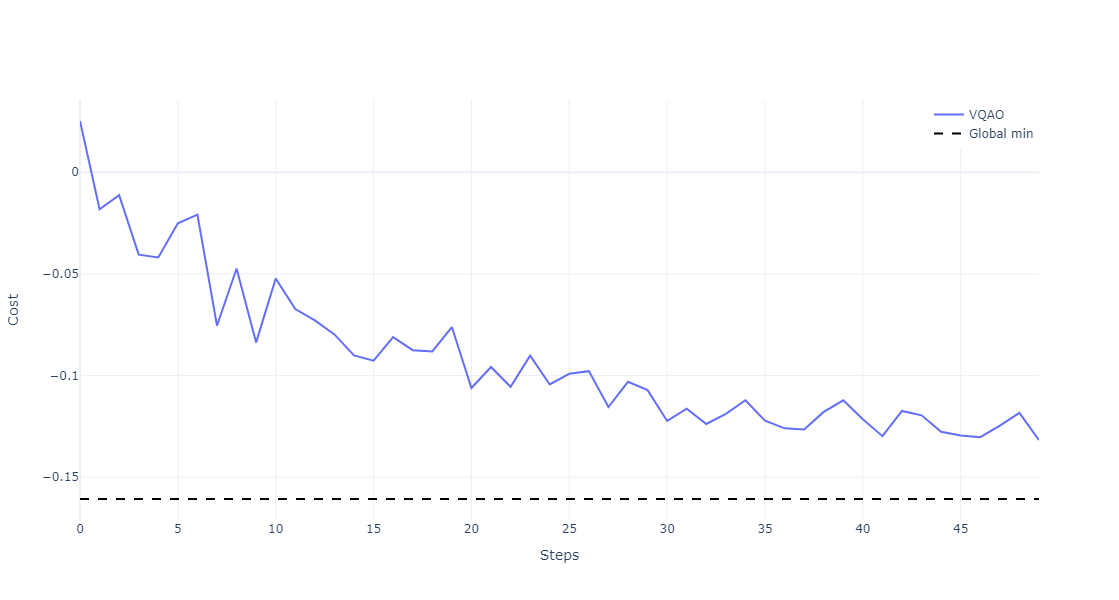

In [24]:
fig = go.Figure()
min = -0.16076947613422413

fig.add_trace(go.Scatter(
    x=df["iteration_number"],
    y=df["cost"], mode='lines',
    name='VQAO'))
fig.add_trace(go.Scatter(
    x=[df["iteration_number"].min(), df["iteration_number"].max()],
    y=[min, min],
    mode='lines',
    name='Global min',
    line=dict(dash='dash', color='black')
))
fig.update_layout(
    xaxis_title="Steps",
    yaxis_title="Cost",
    template="plotly_white",
    width=950,
    height=600
)
fig.update_layout(
    legend=dict(
        x=1,
        y=1,
        xanchor='right',
        yanchor='top'
    )
)
fig.show()

In [25]:
optimized_cost = np.min(df['cost'])
print(optimized_cost)

-0.13179493090302358
